## This notebook creates figs and tables related to supervised loss's bounds in the paper.

In [1]:
import itertools
import re
from pathlib import Path


import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tabulate
import yaml

from utils import get_weight_path_in_current_system, filter_ag

%matplotlib inline
sns.set_context("paper", font_scale=2.0)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["text.usetex"] = True

## Load mean classifier and linear results

In [2]:
ag_targets = filter_ag()

In [3]:
datasets = ("cifar10", "cifar100", "ag_news")


rows = []
for dataset in datasets:
    for results_path_per_classifier in Path(f"../results/{dataset}/eval/").iterdir():
        result_path_generator = results_path_per_classifier.glob("**/results.json")
        classifier = results_path_per_classifier.name

        for p in result_path_generator:
            
            # load config
            with open(p.parent / ".hydra" / "config.yaml") as f:
                config = yaml.load(f, Loader=yaml.FullLoader)

                use_projection_head = config["experiment"]["use_projection_head"]
                seed = config["experiment"]["seed"]

                normalize = True                
                if classifier == "linear":
                    normalize = config["experiment"]["normalize"]

            weights_path = config["experiment"]["target_weight_file"]

            # skip not best weights
            if dataset == "ag_news" and weights_path not in ag_targets:
                continue
            
            self_sup_path = Path(get_weight_path_in_current_system(weights_path)).parent
            with open(self_sup_path / ".hydra" / "config.yaml") as f:
                config = yaml.load(f, Loader=yaml.FullLoader)
                num_mini_batches = config["experiment"]["batches"]
                epoch = config["experiment"]["epochs"]
                
                if dataset == "ag_news":
                    d = config["architecture"]["embedding_dim"]
                else:
                    d = config["parameter"]["d"]
                    
                t = config["loss"]["temperature"]
                
                if "augmentation_type" in config["dataset"]:
                    aug_type = config["dataset"]["augmentation_type"]
                else:
                    aug_type = "simclr"
                
                
            # load classification results
            with open(p) as f:
                classification_results = json.load(f)

                val_accuracies = []
                for key, v in classification_results.items():
                    if "val_acc" in v:
                        k = "val_acc"
                    else:
                        k = "highest_val_acc"

                    val_accuracies.append(v[k] * 100.)
                val_acc = max(val_accuracies)


            rows.append([seed, dataset, aug_type, classifier, num_mini_batches, use_projection_head, normalize, val_acc])

columns = ("seed", "dataset", "aug_type", "classifier", "neg", "projection head", "normalize", "val acc")
acc_df = pd.DataFrame(rows, columns=columns).sort_values(by=["seed", "dataset", "aug_type", "classifier", "neg", "projection head"])
acc_df

,seed,dataset,aug_type,classifier,neg,projection head,normalize,val acc
143,7,ag_news,erase,centroid,16,True,True,87.289474
144,7,ag_news,erase,centroid,32,True,True,88.407895
147,7,ag_news,erase,centroid,64,True,True,89.131579
152,7,ag_news,erase,centroid,128,True,True,89.539474
150,7,ag_news,erase,centroid,256,True,True,89.210526
...,...,...,...,...,...,...,...,...
69,13,cifar100,simclr,linear,768,True,True,46.090000
97,13,cifar100,simclr,linear,896,False,False,59.220000
70,13,cifar100,simclr,linear,896,True,True,45.310000
93,13,cifar100,simclr,linear,1024,False,False,59.640000


## cifar 10

45 rows
- 3 classification: mean, two types of linear
- 3 random seeds
- 5 negs: {32, 64, 128, 256, 512}

## cifar100
72 rows
- 3 classifications
- 3 random seeds
- 8 negs: {128, 256, 384, 512, 640, 768, 896, 1024}

## ag news
108 rows

- 3 classification
- 3 random seeds
- 6 negs
- 2 augmentation type



In [4]:
# check
for dataset in datasets:
    print(dataset, len(acc_df[acc_df["dataset"] == dataset]))


cifar10 45
cifar100 72
ag_news 108


In [5]:
def create_df(dataset: str) -> tuple:
    # the values is taken from `./coupon.ipynb`
    theoretical_upsilon_for_CIFAR100 = {128: 0.0004517171443332115, 256: 0.0005750103110269027}

    # fetch bound values for varying negative samples

    rows = []
    for path_to_bound_in_json in Path(f"../results/{dataset}/analysis/bound/").glob("**/bounds.json"):

        with open(path_to_bound_in_json.parent / ".hydra" / "config.yaml") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
            seed = config["experiment"]["seed"]
            weights = config["experiment"]["target_weight_file"]            
        
        # skip not best weights for AG newsS
        if dataset == "ag_news" and weights not in ag_targets:
            continue

        sub_class_per_super_class = 1
        if dataset == "ag_news" and "num_classes_per_class" in config["experiment"]:
            sub_class_per_super_class = config["experiment"]["num_classes_per_class"]
            
        self_sup_path = Path(get_weight_path_in_current_system(config["experiment"]["target_weight_file"])).parent            
        with open(self_sup_path / ".hydra" / "config.yaml") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
            
        if "augmentation_type" in config["dataset"]:
            aug_type = config["dataset"]["augmentation_type"]
        else:
            aug_type = "simclr"

        num_mini_batches = config["experiment"]["batches"]

        # load bound values
        with open(path_to_bound_in_json) as f:
            results = json.load(f)
        
        k = "training-validation"
        simclr_loss = results[k]["SimCLR_loss"]
        original_SimCLR_loss = results[k]["Original_SimCLR_loss"]
        gap = results[k]["assumption_value"]

        # proposed bound values
        sup_loss = results[k]["sup_loss"] / 2.
        partial_sup_loss = results[k]["partial_sup_loss"] / 2.
        collision = results[k]["conflict_term"]
        bound = results[k]["bound"] + gap
        upsilon = results[k]["upsilon"]

        # replace 0 with theoretical value to avoid zero devide
        if upsilon == 0.:
            upsilon = theoretical_upsilon_for_CIFAR100[num_mini_batches]

        # calculate the upper bound of supervised loss of proposed bound
        proposed_supervised_upper_bound = 2. * simclr_loss - partial_sup_loss - collision - 2. * gap
        proposed_supervised_upper_bound /= upsilon

        # CURL's bound related values
        curl_tau = results[k]["curl_tau"]
        curl_sup_loss = results[k]["curl_sup_loss"]
        # note: CURL's partial loss cotains `results[k]["curl_sup_loss"]`
        curl_partial_sup_loss = results[k]["curl_partial_sup_loss"] - curl_sup_loss
        curl_bound = results[k]["curl_bound"] + gap

        # calculate the upper bound of supervised loss of CURL
        # tau and 1-tau are already included in sub, sup, and collision terms
        curl_supervised_upper_bound = simclr_loss - curl_partial_sup_loss - collision - gap
        curl_supervised_upper_bound /= (1. - curl_tau)

        val_accuracies = []
        # linear with head's validation accuracy
        common_condition = (acc_df["seed"] == seed) & (acc_df["dataset"] == dataset) & (
                    acc_df['neg'] == num_mini_batches)
        
        if dataset == "ag_news":
            common_condition = common_condition & (acc_df["aug_type"] == aug_type)
            
        linear_head_acc = acc_df.loc[(acc_df["normalize"]) & (acc_df["projection head"]) & (
            acc_df['classifier'] == "linear") & common_condition]["val acc"].values[0]

        val_accuracies.append(linear_head_acc)

        # centroids
        val_accuracies.append(
            acc_df.loc[(acc_df['classifier'] == "centroid") & common_condition]["val acc"].values[0]
        )
        
        # linear without head's validation accuracy
        val_accuracies.append(
            acc_df.loc[(~acc_df["projection head"]) & (acc_df["classifier"] == "linear") & common_condition]["val acc"].values[0])
        
        # sub-classes accuracy on ag news
        if dataset == "ag_news":
            val_accuracies.append(results[k]["centroid_accuracy"])
            
        
        rows.append([
                        num_mini_batches, seed, aug_type, sub_class_per_super_class,
                        simclr_loss, original_SimCLR_loss, gap,
                        upsilon, bound, sup_loss, partial_sup_loss, collision, proposed_supervised_upper_bound,
                        curl_sup_loss, curl_partial_sup_loss, curl_bound, curl_tau, curl_supervised_upper_bound,
                    ] + val_accuracies)


    columns = [
        "neg", "seed", "aug_type", "sub_class/sup_class",
        "SimCLR loss", "Original SimCLR loss", "gap",
        "upsilon", "Bound", "sup. loss", "partial sup. loss", "Collision", "proposed_supervised_upper_bound",
        "CURL sup. loss", "CURL partial sup. loss", "CURL bound", "curl_tau", "curl_supervised_upper_bound",
        "val. acc.", "Mean val. acc.", "wo val. acc."
    ]
    if dataset == "ag_news":
        columns.append("Mean val. acc. via sub_class")
        
    df = pd.DataFrame(rows, columns=columns)
    df = df.sort_values(by=["seed", "neg", "aug_type", "sub_class/sup_class"])

    groups = ["neg", "aug_type", "sub_class/sup_class"]
    return df.groupby(groups).mean().reset_index(), df.groupby(groups).std().reset_index()


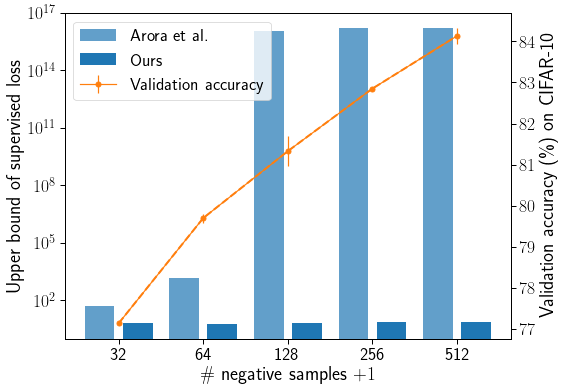

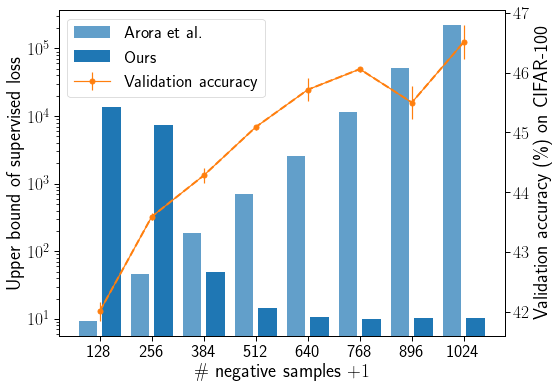

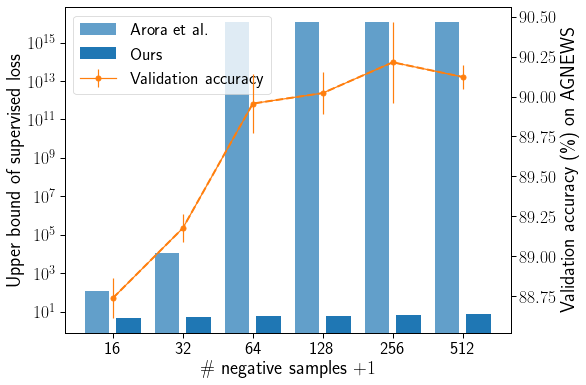

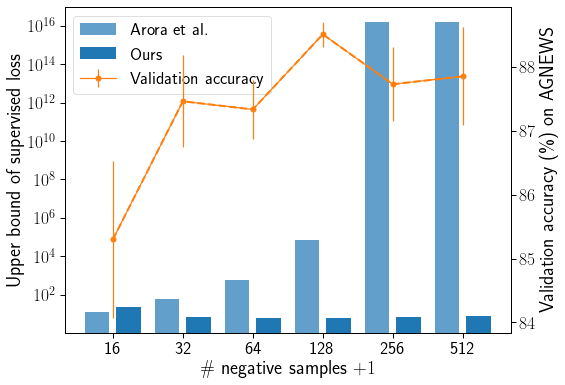

In [8]:
width = 0.35
alpha = 0.7

for dataset in datasets:
        
    _df, _df_std = create_df(dataset)
    for aug_type, num_sub_class in itertools.product(set(_df["aug_type"]), set(_df["sub_class/sup_class"])):
        if aug_type == "replace":
            continue

        condition = (_df["aug_type"] == aug_type) & (_df["sub_class/sup_class"] == num_sub_class)
        df = _df[condition]
        df_std = _df_std[condition]
    
        negs = df["neg"].values  # negative samples

        sup_loss_color = "tab:orange"
        partial_loss_color = "tab:blue"

        fig, ax1 = plt.subplots(figsize=(8, 6))

        # CURL
        x = np.arange(len(negs)) - width / 2 - 0.05

        ## upper bound of supervised loss
        curl_supervised_bound = df["curl_supervised_upper_bound"].values

        p1 = ax1.bar(
            x, curl_supervised_bound, width, color=partial_loss_color, alpha=alpha, label="Arora et al."
        )

        # proposed
        x = np.arange(len(negs)) + width / 2 + 0.05

        # proposed upper bound of supervised loss
        proposed_supervised_bound = df["proposed_supervised_upper_bound"].values

        p2 = ax1.bar(
            x, proposed_supervised_bound, width, color=partial_loss_color, label="Ours"
        )

        # supervised
        ax1.set_yscale("log")
        ax1.set_ylabel("Upper bound of supervised loss")
        ax1.set_xlabel("\# negative samples $+ 1$")

        # linear with normalized feature's accuracy
        ax2 = ax1.twinx()
        x = np.arange(len(df["neg"].values))
        y = df["val. acc."].values        
        yerr = df_std["val. acc."].values        

        if dataset == "ag_news":
            if num_sub_class == 2:
                y = df["Mean val. acc. via sub_class"].values
                yerr = df_std["Mean val. acc. via sub_class"].values
                    
        color = "tab:orange"
        ax2.plot(x, y, "--", linewidth=2, color=color, mfc=color, mec=color)
        p3 = ax2.errorbar(x, y, yerr=yerr, marker="o", markersize=5, label="Validation accuracy", color=color, mfc=color,
                          mec=color)

        ax2.set_ylabel("Validation accuracy (\%) on {}".format(dataset.replace("_", "").upper()).replace("1", "-1"))

        plt.xticks(x, df["neg"].values)

        lines = [p1, p2, p3]
        ax1.legend(lines, [l.get_label() for l in lines], loc=2)
        
        if "cifar" in dataset:
            plt.savefig("../../doc/figs/{}_bounds.pdf".format(dataset))
        else:
            plt.savefig("../../doc/figs/{}_{}_{}_bounds.pdf".format(dataset, aug_type, num_sub_class))
        plt.show()
        


## Tables

In [9]:
with open("upper_bound_collision.json") as f:
    upper_bound_collision = json.load(f)
upper_bound_collision

{'cifar10': {'Without Head': {'32': [0.20344002544879913,
    0.20120733976364136,
    0.2020581066608429],
   '64': [0.20893289148807526, 0.21036161482334137, 0.20859843492507935],
   '128': [0.2195030301809311, 0.21415293216705322, 0.21780523657798767],
   '256': [0.2383182793855667, 0.248433455824852, 0.2456970363855362],
   '512': [0.3776441514492035, 0.38166579604148865, 0.37573105096817017]},
  'Head': {'32': [0.6004360914230347, 0.600628137588501, 0.6010799407958984],
   '64': [0.6064498424530029, 0.6057505011558533, 0.6067995429039001],
   '128': [0.6113784909248352, 0.6098403334617615, 0.6118673086166382],
   '256': [0.6158205270767212, 0.6150308847427368, 0.6146792769432068],
   '512': [0.6224831342697144, 0.6226506233215332, 0.6232998967170715]}},
 'cifar100': {'Head': {'128': [0.5233954787254333,
    0.5218632221221924,
    0.5240010023117065],
   '256': [0.5195236206054688, 0.5185999870300293, 0.5196577906608582],
   '384': [0.515285074710846, 0.5151933431625366, 0.5167869

In [10]:
cifar10_df, _ = create_df("cifar10")
cifar100_df, _ = create_df("cifar100")

# select four candidates of K+1 due to the page limit
cifar10_candidates = (32, 128, 256, 512)
cifar100_candidates = (128, 256, 512, 1024)
cifar10_df = pd.concat([cifar10_df[cifar10_df["neg"] == k] for k in cifar10_candidates])
cifar100_df = pd.concat([cifar100_df[cifar100_df["neg"] == k] for k in cifar100_candidates])

rows = []

headers = ["K+1"] + [""] + list(cifar10_df["neg"].values) + [" "] + list(cifar100_df["neg"].values)
rows.append(
    ["tau"] + [""] + list(cifar10_df["curl_tau"].values) + [" "] + list(cifar100_df["curl_tau"].values))
rows.append(
    ["upsilon"] + [""] + list(cifar10_df["upsilon"].values) + [" "] + list(cifar100_df["upsilon"].values))
rows.append(
    ["mu acc"] + [""] + list(cifar10_df["Mean val. acc."].values) + [" "] + list(cifar100_df["Mean val. acc."].values))
rows.append(
    ["Linear acc"] + [""] + list(cifar10_df["val. acc."].values) + [" "] + list(cifar100_df["val. acc."].values))
rows.append(
    ["Linear acc w/o"] + [""] + list(cifar10_df["wo val. acc."].values) + [" "] + list(cifar100_df["wo val. acc."].values))

rows.append(["Linfo"] + ["cref{eq:test-self-sup-loss}"] + list(cifar10_df["SimCLR loss"].values) + [" "] + list(
    cifar100_df["SimCLR loss"].values))
rows.append(["d(fbf)"] + ["cref{eq:mean-supervised}"] + list(cifar10_df["gap"].values) + [" "] + list(
    cifar100_df["gap"].values))

rows.append(["dagger Linfo bound"] + ["cref{eq:decompose-sup}"] + list(cifar10_df["CURL bound"].values) + [" "] + list(
    cifar100_df["CURL bound"].values))
rows.append(["hspace{2ex} daggerCollision"] + [""] + list(cifar10_df["Collision"].values) + [" "] + list(
    cifar100_df["Collision"].values))
rows.append(["hspace{2ex} dagger L sup"] + [""] + list(cifar10_df["CURL sup. loss"].values) + [" "] + list(
    cifar100_df["CURL sup. loss"].values))
rows.append(["hspace{2ex} dagger L sub "] + [""] + list(cifar10_df["CURL partial sup. loss"].values) + [" "] + list(
    cifar100_df["CURL partial sup. loss"].values))

rows.append(["Linfo bound"] + ["cref{eq:proposed-bound}"] + list(cifar10_df["Bound"].values) + [" "] + list(
    cifar100_df["Bound"].values))

rows.append(
    ["hspace{2ex} L sup"] + [""] + list(cifar10_df["sup. loss"].values) + [" "] + list(cifar100_df["sup. loss"].values))
rows.append(["hspace{2ex} L sub"] + [""] + list(cifar10_df["partial sup. loss"].values) + [" "] + list(
    cifar100_df["partial sup. loss"].values))

cifar10_upper_boud = [np.mean(upper_bound_collision["cifar10"]["Head"][str(k)]) for k in cifar10_candidates]
cifar100_upper_boud = [np.mean(upper_bound_collision["cifar100"]["Head"][str(k)]) for k in cifar100_candidates]
rows.append(["Collision bound"] + ["cref{eq:upper-bound-collision}"] + cifar10_upper_boud + [" "] + cifar100_upper_boud)

tex = tabulate.tabulate(
    rows, floatfmt=".2f", headers=headers, tablefmt="latex_booktabs"
).replace("mu", "$\mu$").replace("Linfo", "$\Lin$").replace("L sub", "$L^{\mu}_{\mathrm{sub}}$").replace("L sup",
                                                                                                         "$L^{\mu}_{\mathrm{sup}}$").replace(
    "K+1", "$K+1$").replace("dagger", "$^{\dagger}$").replace("$ $", "").replace(" d(fbf) ",
                                                                                 " $d(\mathbf{f})$ ").replace("\{",
                                                                                                              "{").replace(
    "\}", "}").replace("cref", "\cref").replace("hspace", "\hspace")

tex = re.sub(r"(-?\d+\.?\d+)", "$\\1$", tex)

print(
    tex
)


\begin{tabular}{llrrrrlrrrr}
\toprule
 $K+1$                         &                                &    $32$ &   $128$ &   $256$ &   $512$ &     &   $128$ &   $256$ &   $512$ &   $1024$ \\
\midrule
 tau                         &                                &  $0.96$ &  $1.00$ &  $1.00$ &  $1.00$ &     &  $0.72$ &  $0.92$ &  $0.99$ &   $1.00$ \\
 upsilon                     &                                &  $0.69$ &  $1.00$ &  $1.00$ &  $1.00$ &     &  $0.00$ &  $0.00$ &  $0.62$ &   $1.00$ \\
 $\mu$ acc                      &                                & $72.75$ & $77.22$ & $78.60$ & $80.12$ &     & $32.74$ & $34.22$ & $35.98$ &  $37.50$ \\
 Linear acc                  &                                & $77.13$ & $81.33$ & $82.85$ & $84.13$ &     & $42.01$ & $43.59$ & $45.09$ &  $46.52$ \\
 Linear acc w/o              &                                & $82.02$ & $85.43$ & $86.68$ & $87.66$ &     & $57.92$ & $58.91$ & $59.30$ &  $59.46$ \\
 $\Lin$                       & \cre

## Whole table


In [11]:
for dataset in datasets:
    if "cifar" not in dataset:
        continue
    df, _ = create_df(dataset)

    rows = []

    headers = ["K+1"] + [""] + list(df["neg"].values)
    rows.append(["mu acc"] + [""] + list(df["Mean val. acc."].values))
    rows.append(["Linear acc"] + [""] + list(df["val. acc."].values))
    rows.append(["Linfo"] + ["cref{eq:test-self-sup-loss}"] + list(df["SimCLR loss"].values))
    rows.append(["d(fbf)"] + ["cref{eq:mean-supervised}"] + list(df["gap"].values))

    rows.append(["dagger Linfo bound"] + ["cref{eq:decompose-sup}"] + list(df["CURL bound"].values))
    rows.append(["hspace{2ex} daggerCollision"] + [""] + list(df["Collision"].values))
    rows.append(["hspace{2ex} dagger L sup"] + [""] + list(df["CURL sup. loss"].values))
    rows.append(["hspace{2ex} dagger L sub "] + [""] + list(df["CURL partial sup. loss"].values))

    rows.append(["Linfo bound"] + ["cref{eq:proposed-bound}"] + list(df["Bound"].values))

    rows.append(["hspace{2ex} L sup"] + [""] + list(df["sup. loss"].values))
    rows.append(["hspace{2ex} L sub"] + [""] + list(df["partial sup. loss"].values))

    upper_bound = [np.mean(upper_bound_collision[dataset]["Head"][str(k)]) for k in df["neg"].values]
    rows.append(["Collision bound"] + ["cref{eq:upper-bound-collision}"] + upper_bound)

    tex = tabulate.tabulate(
        rows, floatfmt=".2f", headers=headers, tablefmt="latex_booktabs"
    ).replace("mu", "$\mu$").replace("Linfo", "$\Lin$").replace("L sub", "$L^{\mu}_{\mathrm{sub}}$").replace("L sup",
                                                                                                             "$L^{\mu}_{\mathrm{sup}}$").replace(
        "K+1", "$K+1$").replace("dagger", "$^{\dagger}$").replace("$ $", "").replace(" d(fbf) ",
                                                                                     " $d(\mathbf{f})$ ").replace("\{",
                                                                                                                  "{").replace(
        "\}", "}").replace("cref", "\cref").replace("hspace", "\hspace")

    tex = re.sub(r"(-?\d+\.?\d+)", "$\\1$", tex)

    print(
        tex
    )

    fname = "../../doc/tabs/{}-all-bound.tex".format(dataset)

    with open(fname, "w") as f:
        f.write(tex)
    print()


\begin{tabular}{llrrrrr}
\toprule
 $K+1$                         &                                &    $32$ &    $64$ &   $128$ &   $256$ &   $512$ \\
\midrule
 $\mu$ acc                      &                                & $72.75$ & $75.30$ & $77.22$ & $78.60$ & $80.12$ \\
 Linear acc                  &                                & $77.13$ & $79.70$ & $81.33$ & $82.85$ & $84.13$ \\
 $\Lin$                       & \cref{eq:test-self-sup-loss}    &  $2.02$ &  $2.64$ &  $3.29$ &  $3.96$ &  $4.64$ \\
 $d(\mathbf{f})$                      & \cref{eq:mean-supervised}       & $-1.16$ & $-1.17$ & $-1.18$ & $-1.18$ & $-1.19$ \\
 $^{\dagger}\Lin$ bound          & \cref{eq:decompose-sup}         &  $0.23$ &  $0.76$ &  $1.41$ &  $2.08$ &  $2.75$ \\
 \hspace{2ex} $^{\dagger}$Collision &                                &  $1.32$ &  $1.93$ &  $2.58$ &  $3.26$ &  $3.94$ \\
 \hspace{2ex} $^{\dagger}L^{\mu}_{\mathrm{sup}}$    &                                &  $0.05$ &  $0.00$ &  $0.00$ &  $0.00

## AG news dataset

In [12]:
_df, _ = create_df("ag_news")
candidates = [16, 32, 64, 128, 256, 512]

for aug_type, num_sub_class in itertools.product(set(_df["aug_type"]), set(_df["sub_class/sup_class"])):
    if num_sub_class != 1 or aug_type != "erase":
        continue

    print(aug_type, num_sub_class)
    
    condition = (_df["aug_type"] == aug_type) & (_df["sub_class/sup_class"] == num_sub_class)
    df = _df[condition]

    rows = []

    headers = ["K+1"] + [""] + list(df["neg"].values)
    rows.append(
        ["$\\tau$"] + [""] + list(df["curl_tau"].values)
    )
    rows.append(
        ["$\\upsilon$"] + [""] + list(df["upsilon"].values)
    )
    rows.append(
        ["mu acc"] + [""] + list(df["Mean val. acc."].values)
    )
    if num_sub_class == 2:
        
        rows.append(
            ["mu via sub-class acc"] + [""] + list(df["Mean val. acc. via sub_class"].values)
        )        
    rows.append(
        ["Linear acc"] + [""] + list(df["val. acc."].values)
    )
    rows.append(
        ["Linear acc w/o"] + [""] + list(df["wo val. acc."].values))

    rows.append(["Linfo"] + ["cref{eq:test-self-sup-loss}"] + list(df["SimCLR loss"].values))
    rows.append(["d(fbf)"] + ["cref{eq:mean-supervised}"] + list(df["gap"].values))

    rows.append(["dagger Linfo bound"] + ["cref{eq:decompose-sup}"] + list(df["CURL bound"].values))
    rows.append(["daggerCollision"] + [""] + list(df["Collision"].values))
    rows.append(["dagger L sup"] + [""] + list(df["CURL sup. loss"].values))
    rows.append(["dagger L sub "] + [""] + list(df["CURL partial sup. loss"].values))

    rows.append(["Linfo bound"] + ["cref{eq:proposed-bound}"] + list(df["Bound"].values))

    rows.append(
        ["L sup"] + [""] + list(df["sup. loss"].values))
    rows.append(["L sub"] + [""] + list(df["partial sup. loss"].values))

    upper_boud = [np.mean(upper_bound_collision["ag_news-{}".format(aug_type)]["Head"][str(k)]) for k in candidates]
    rows.append(["Collision bound"] + ["cref{eq:upper-bound-collision}"] + upper_boud)

    rows.append(
        ["dagger ln L sup upper bound "] + [""] + list(np.log(df["curl_supervised_upper_bound"].values))
    )

    rows.append(
        ["ln L sup upper bound "] + [""] + list(np.log(df["proposed_supervised_upper_bound"].values))
    )

    tex = tabulate.tabulate(
        rows, floatfmt=".2f", headers=headers, tablefmt="github"
    ).replace("mu", "$\mu$").replace("Linfo", "$L_{\mathrm{Info}}$").replace("L sub", "$L^{\mu}_{\mathrm{sub}}$").replace("L sup",
                                                                                                             "$L^{\mu}_{\mathrm{sup}}$").replace(
        "K+1", "$K+1$").replace("dagger", "$^{\dagger}$").replace("$ $", "").replace(" d(fbf) ",
                                                                                     " $d(\mathbf{f})$ ").replace("\{",
                                                                                                                  "{").replace(
        "\}", "}").replace("cref", "\cref").replace("hspace", "\hspace").replace("ln $", "$\ln ")

    tex = re.sub(r"(-?\d+\.?\d+)", "$\\1$", tex)


    print(
        tex
    )



erase 1
| $K+1$                         |                                |    $16$ |    $32$ |    $64$ |   $128$ |   $256$ |   $512$ |
|-----------------------------|--------------------------------|-------|-------|-------|-------|-------|-------|
| $\tau$                      |                                |  $0.99$ |  $1.00$ |  $1.00$ |  $1.00$ |  $1.00$ |  $1.00$ |
| $\upsilon$                  |                                |  $0.96$ |  $1.00$ |  $1.00$ |  $1.00$ |  $1.00$ |  $1.00$ |
| $\mu$ acc                      |                                | $87.09$ | $88.41$ | $89.12$ | $89.38$ | $89.47$ | $89.54$ |
| Linear acc                  |                                | $88.74$ | $89.18$ | $89.96$ | $90.02$ | $90.21$ | $90.12$ |
| Linear acc w/o              |                                | $87.11$ | $87.94$ | $89.05$ | $89.49$ | $89.62$ | $89.45$ |
| $L_{\mathrm{Info}}$                       | \cref{eq:test-self-sup-loss}    |  $1.23$ |  $1.77$ |  $2.37$ |  $3.02$ |  $3.